In [1]:
#import the neccesary libraries
from datetime import datetime
import os
import seaborn as sns
import matplotlib.pyplot as plt
import psycopg2
import time
import matplotlib as mpl
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
import re
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import shap
from fbprophet import Prophet
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
pd.set_option('display.max_columns', None)

/Users/hyacinthampadu/miniforge3/envs/py36/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
Db_host='127.0.0.1'
Db_name='postgres'
Db_user='postgres'
Db_pass='Brunei42i'

In [3]:
conn = psycopg2.connect(host=Db_host, dbname=Db_name, user=Db_user,password=Db_pass)
conn.set_session(autocommit=True)
cur = conn.cursor()

In [4]:
parallel=pd.read_sql_query("SELECT * FROM parallel_trades",conn)
parallel.head()

pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy


,chain,collectionaddress,collectionname,exchange,logindex,maker,price,quotecurrency,side,taker,thumbnailurl,timestamp,tokenid,tx,txindex,date,id
0,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,514,0x661d0eaf85b3af039aa457473e5d448b2ce38ce6,0.0013,ETH,buy,0xb9dfffe3dd0956455ebba025bc3f6de4ca6bed87,https://storage.googleapis.com/parsec-nft-stor...,1649804649,10545.0,0xcc40b548c1d454b42c0d8a06d8adb23ffb514b63fa2d...,210.0,2022-04-12,5111
1,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,179,0x4050fb6fac4a6dbf61b63d6cba8e344a2ee9057d,0.0200,ETH,buy,0xb587cbaec20ef78296e1d3b105b5b6aa4ff0c3b4,https://storage.googleapis.com/parsec-nft-stor...,1649804054,10566.0,0xc9f1d2dd0b0afc70f254691ea119d1936288bfc261ae...,72.0,2022-04-12,5947
2,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,99,0x2f02c4e2da54a0df1f40dfec773ded5125dc28bf,0.0100,ETH,buy,0x215e14543142af17e2cb0ef08db5c126776d59f4,https://storage.googleapis.com/parsec-nft-stor...,1649795459,10568.0,0xd8bc48264001571f79164bfa5c409d5eedecd56ceff6...,64.0,2022-04-12,14484
3,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,269,0x91b2642e5317074f25a47dc2b65c280e9b3427a0,0.0380,ETH,sell,0xbc0139b7b925cd3aaf818880ff45ed15b077e111,https://storage.googleapis.com/parsec-nft-stor...,1649795052,10503.0,0x1cc4302565f7c9c1194d601e68e84389dbd88ac856d2...,127.0,2022-04-12,14655
4,eth,0x76be3b62873462d2142405439777e971754e8e77,Parallel Alpha,opensea,282,0x6c9af2c7b46b8c94061088a1f3bbf9b6651fc34c,0.0010,ETH,buy,0x6917b4f314e3e1e34750432f3c4fa6d6ebd878e0,https://storage.googleapis.com/parsec-nft-stor...,1649793126,10556.0,0x9ac3ba9439a650835fe905fd55571dafb14e5e5bc81d...,138.0,2022-04-12,16319


In [5]:
from datetime import datetime
parallel['date']=parallel['timestamp'].apply(lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [6]:
parallel['date']=pd.to_datetime(parallel['date'])
parallel=parallel[parallel['date']>'2021-08-01']

In [7]:
parallel=parallel[parallel['price']>=0]

In [8]:
df=parallel.groupby([pd.Grouper(key='date', freq='d'),  'collectionname']).agg({
    'maker':['nunique'],
    'taker':['nunique'],
    'thumbnailurl':['nunique'],
    'tx':['nunique'],
    #'logindex':['mean'],
    #'txindex':['mean'],
    'price':['min','median']})

In [9]:
len(df)

255

In [10]:
def flatten_columns(df, prefix=''):
    columns = []
    for cs in df:
        if type(cs) is str:
            cs = re.sub('\W+','_', cs)
        elif type(cs) is not list and type(cs) is not tuple:
            print (cs)
            cs = str(cs)
        else:
            cs = re.sub("\W+", "", "".join([str(c) for c in cs]))
        cs = cs.lower()
        if prefix:
            cs = prefix + '' + cs
        cs = re.sub('\+$', '', cs)
        columns.append(cs)
    return columns

In [11]:
df.columns=flatten_columns(df)

In [12]:
df=df.reset_index()

In [13]:
df.head()

,date,collectionname,makernunique,takernunique,thumbnailurlnunique,txnunique,pricemin,pricemedian
0,2021-08-01,Parallel Alpha,228,230,108,641,0.0200,0.1900
1,2021-08-02,Parallel Alpha,745,804,113,3632,0.0060,0.0880
2,2021-08-03,Parallel Alpha,887,937,119,3212,0.0230,0.1290
3,2021-08-04,Parallel Alpha,434,387,98,1230,0.0189,0.1000
4,2021-08-05,Parallel Alpha,339,276,92,728,0.0160,0.1149


In [14]:
df=df.rename(columns={'pricemin':'floor_price','pricemedian':'median_price',
                  'makernunique':'num_of_sellers','takernunique':'number_of_buyers','thumbnailurlnunique':'volume_of_assets_traded',
                  'txnunique':'number_of_transcations_index'})

In [15]:
df.head()

,date,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,number_of_transcations_index,floor_price,median_price
0,2021-08-01,Parallel Alpha,228,230,108,641,0.0200,0.1900
1,2021-08-02,Parallel Alpha,745,804,113,3632,0.0060,0.0880
2,2021-08-03,Parallel Alpha,887,937,119,3212,0.0230,0.1290
3,2021-08-04,Parallel Alpha,434,387,98,1230,0.0189,0.1000
4,2021-08-05,Parallel Alpha,339,276,92,728,0.0160,0.1149


In [16]:
corr_matrix = df.corr()
(corr_matrix["floor_price"].sort_values(ascending=False))

floor_price                     1.000000
median_price                    0.821931
number_of_transcations_index    0.047760
number_of_buyers                0.045613
num_of_sellers                 -0.017360
volume_of_assets_traded        -0.334498
Name: floor_price, dtype: float64

<AxesSubplot:>

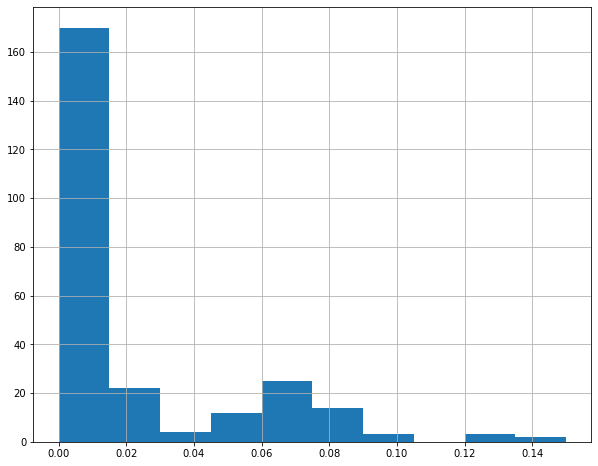

In [17]:
df['floor_price'].hist()

In [18]:
df.head()

,date,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,number_of_transcations_index,floor_price,median_price
0,2021-08-01,Parallel Alpha,228,230,108,641,0.0200,0.1900
1,2021-08-02,Parallel Alpha,745,804,113,3632,0.0060,0.0880
2,2021-08-03,Parallel Alpha,887,937,119,3212,0.0230,0.1290
3,2021-08-04,Parallel Alpha,434,387,98,1230,0.0189,0.1000
4,2021-08-05,Parallel Alpha,339,276,92,728,0.0160,0.1149


<AxesSubplot:>

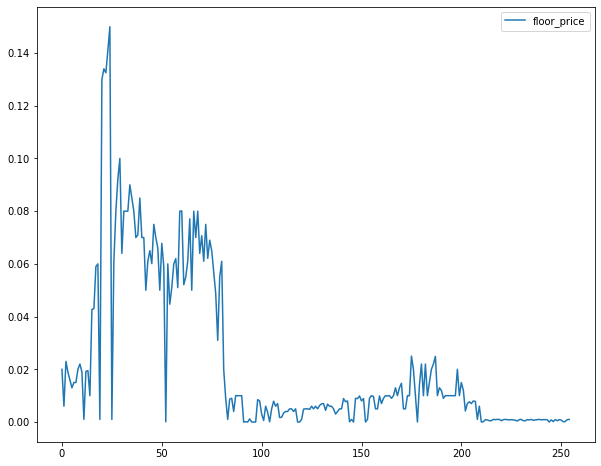

In [19]:
df[['floor_price']].plot(kind='line')

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

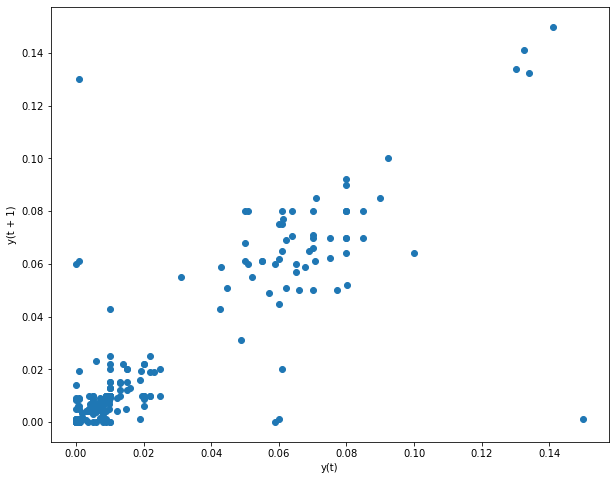

In [20]:
pd.plotting.lag_plot(df['floor_price'],lag=1)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 7)'>

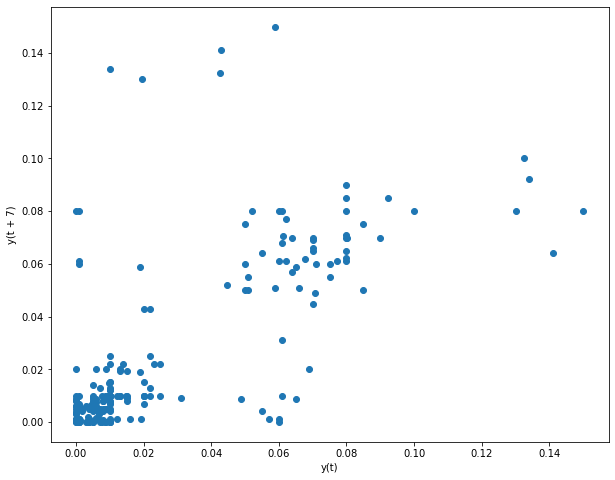

In [21]:
pd.plotting.lag_plot(df['floor_price'],lag=7)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 30)'>

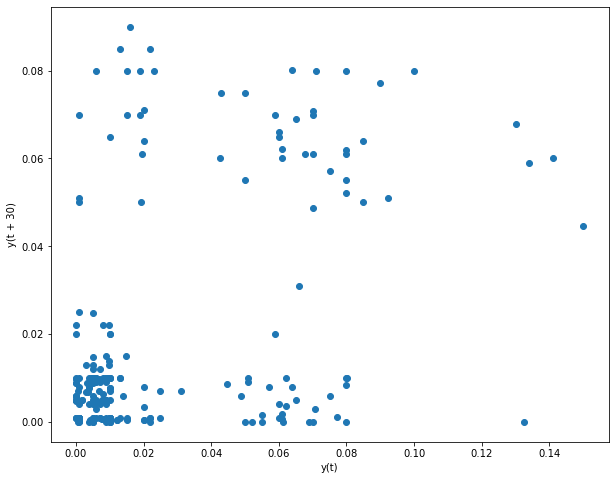

In [22]:
pd.plotting.lag_plot(df['floor_price'],lag=30)

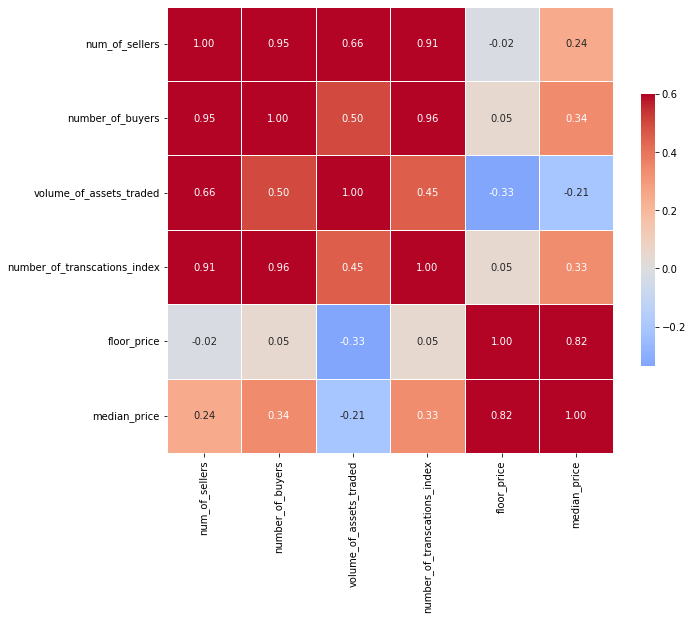

In [23]:
g = sns.heatmap(corr_matrix,  vmax=.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')
g.figure.set_size_inches(10,10)
    
plt.show()

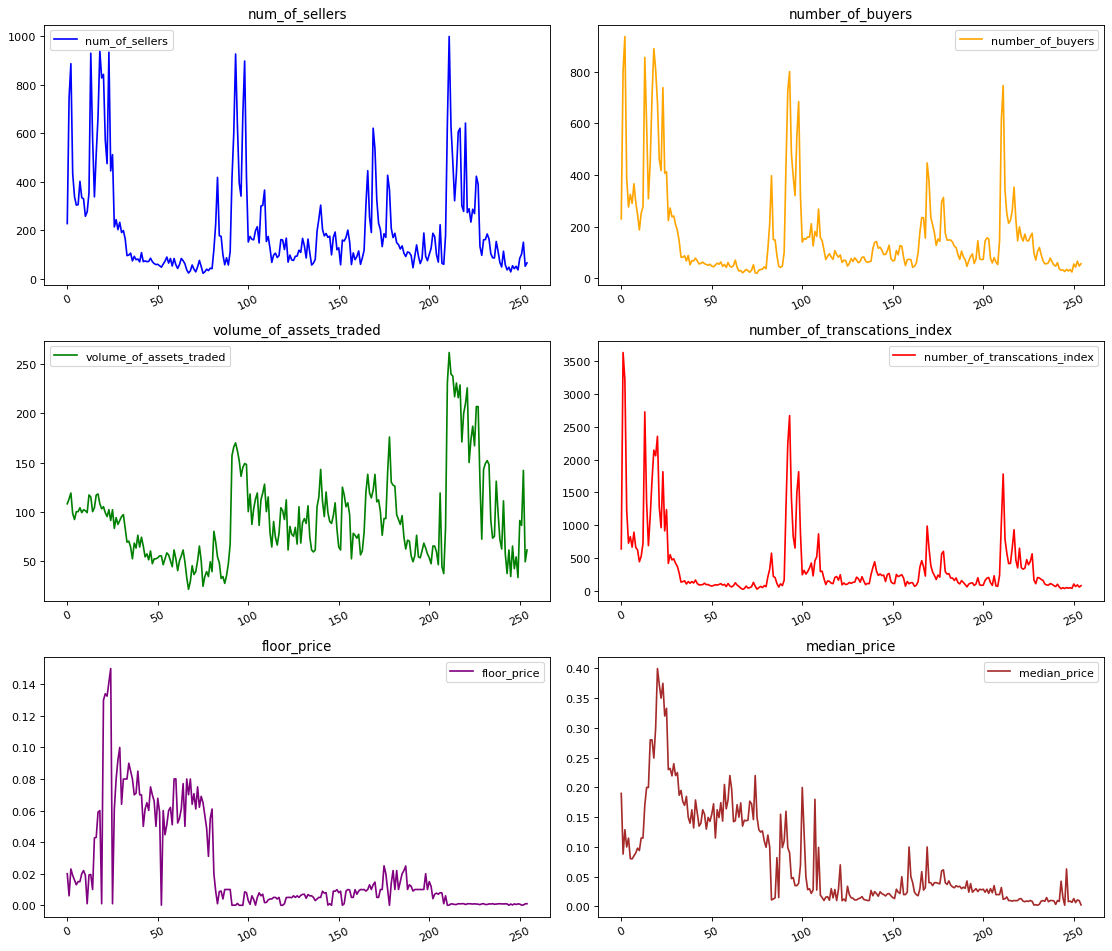

In [24]:
color_list = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]


def Visualize(data):
    features= list(df.select_dtypes(include=[np.number]).columns.values)
    feature_size=len(features)
    fig, axes = plt.subplots(
        nrows=int(np.ceil(feature_size/2)), ncols=2, figsize=(14, feature_size*2), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(feature_size):
        key = features[i]
        c = color_list[i % (len(color_list))]
        t_data = data[key]
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{}".format(key),
            rot=25,
        )
        ax.legend([key])
    plt.tight_layout()


Visualize(df)

In [25]:
result = adfuller(df["floor_price"])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critial Values: {result[4]}')

if result[1] > 0.05 :
  print('Series is not Stationary')
else:
  print('Series is Stationary')

Test Statistics: -1.5440012094160271
p-value: 0.5116432597109977
Critial Values: {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}
Series is not Stationary


In [26]:
def convert_to_stationary(df):
    df=df.diff(periods=1)
    return df

In [27]:
df.head(1)

,date,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,number_of_transcations_index,floor_price,median_price
0,2021-08-01,Parallel Alpha,228,230,108,641,0.02,0.19


In [28]:
non_stationary_cols = df[['floor_price','median_price']]

In [29]:
non_stationary_cols=convert_to_stationary(non_stationary_cols)

In [30]:
non_stationary_cols=non_stationary_cols.fillna(method='backfill')
non_stationary_cols=np.abs(non_stationary_cols)

In [31]:
df=df.drop(columns=['floor_price','median_price'])

In [32]:
df=pd.concat([df,non_stationary_cols],axis=1)

<AxesSubplot:>

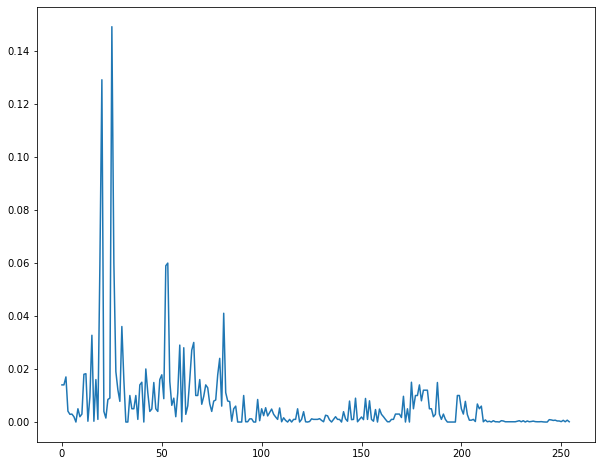

In [33]:
df['floor_price'].plot()

In [34]:
#df=df.fillna(method='backfill')

In [35]:
df.head()

,date,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,number_of_transcations_index,floor_price,median_price
0,2021-08-01,Parallel Alpha,228,230,108,641,0.0140,0.1020
1,2021-08-02,Parallel Alpha,745,804,113,3632,0.0140,0.1020
2,2021-08-03,Parallel Alpha,887,937,119,3212,0.0170,0.0410
3,2021-08-04,Parallel Alpha,434,387,98,1230,0.0041,0.0290
4,2021-08-05,Parallel Alpha,339,276,92,728,0.0029,0.0149


In [36]:
result = adfuller(df["floor_price"])
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critial Values: {result[4]}')

if result[1] > 0.05 :
  print('Series is not Stationary')
else:
  print('Series is Stationary')

Test Statistics: -3.17580562066524
p-value: 0.021428557434188766
Critial Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}
Series is Stationary


In [37]:
df['date'].min(),df['date'].max()

(Timestamp('2021-08-01 00:00:00'), Timestamp('2022-04-12 00:00:00'))

In [38]:
#split data into train and test sets
split_date ='2022-04-01'
df_train = df.loc[df.date <= split_date].copy()
df_test = df.loc[df.date > split_date].copy()

In [39]:
len(df_train), len(df_test)

(244, 11)

In [40]:
def create_features(df, label=None):
    """
    Creates features from column index
    """
    
    X = df[['num_of_sellers','number_of_buyers','volume_of_assets_traded','number_of_transcations_index','median_price']]
    if label:
        y = df[label]
        return X, y
    return X

In [41]:
#Split train and test sets into X (features) and y - (label)
X_train, y_train = create_features(df_train, label='floor_price')
X_test, y_test = create_features(df_test, label='floor_price')

In [42]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [43]:
#Scale the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
param_grid = { 
    'n_estimators': [50,70,60],
    'max_depth': [3,5,4],
    'min_samples_split':[2,3,4]
}
reg = RandomForestRegressor(random_state=0,verbose=0,oob_score=True)
cv_xgb = GridSearchCV(estimator=reg, param_grid=param_grid, cv=5,verbose=0)

cv_xgb.fit(X_train, y_train)
yhat = cv_xgb.best_estimator_.predict(X_test)

In [45]:
cv_xgb.best_params_

{'max_depth': 3, 'min_samples_split': 3, 'n_estimators': 60}

In [46]:
err=pd.DataFrame({'prediction':yhat,'actual': y_test, 'error':y_test-yhat})
err['error'].describe()

count    11.000000
mean     -0.008292
std       0.004788
min      -0.018273
25%      -0.011464
50%      -0.007594
75%      -0.004275
max      -0.002846
Name: error, dtype: float64

In [47]:
df['floor_price'].describe()

count    255.000000
mean       0.006906
std        0.015238
min        0.000000
25%        0.000300
50%        0.002000
75%        0.008150
max        0.149000
Name: floor_price, dtype: float64

In [48]:
#score the model
mae = mean_absolute_error(yhat,y_test)
print("MAE:", mae)

MAE: 0.008292408099976632


In [49]:
#score the model
rmse = np.sqrt(mean_squared_error(yhat,y_test))
print("RMSE:", rmse)

RMSE: 0.009465919830340877


In [50]:
import scipy

In [51]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(yhat, y_test)
'Pvalue:',p_value,'Rvalue:',r_value

('Pvalue:', 0.008787980753444787, 'Rvalue:', 0.7430405076226055)

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:ylabel='floor_price'>

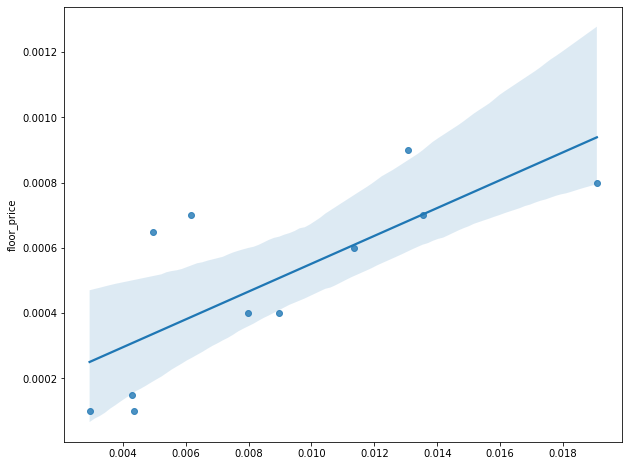

In [52]:
sns.regplot(yhat, y_test)

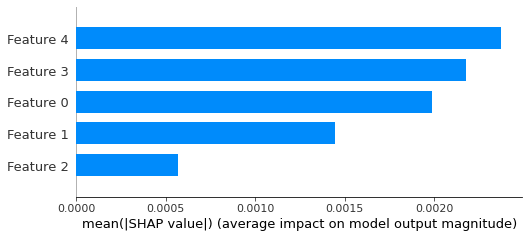

In [53]:
explainer = shap.TreeExplainer(cv_xgb.best_estimator_)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

### Prophet

In [54]:
df.head(2)

,date,collectionname,num_of_sellers,number_of_buyers,volume_of_assets_traded,number_of_transcations_index,floor_price,median_price
0,2021-08-01,Parallel Alpha,228,230,108,641,0.014,0.102
1,2021-08-02,Parallel Alpha,745,804,113,3632,0.014,0.102


In [55]:
df_prophet=df.reset_index()[['date','floor_price','median_price','num_of_sellers','number_of_buyers','volume_of_assets_traded',
                             'number_of_transcations_index']].rename({'date':'ds','floor_price':'y'}, axis='columns')

In [56]:
df_prophet.head()

,ds,y,median_price,num_of_sellers,number_of_buyers,volume_of_assets_traded,number_of_transcations_index
0,2021-08-01,0.0140,0.1020,228,230,108,641
1,2021-08-02,0.0140,0.1020,745,804,113,3632
2,2021-08-03,0.0170,0.0410,887,937,119,3212
3,2021-08-04,0.0041,0.0290,434,387,98,1230
4,2021-08-05,0.0029,0.0149,339,276,92,728


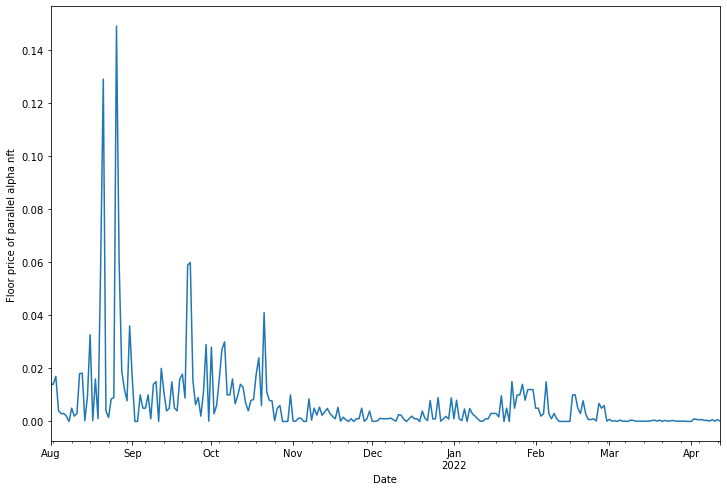

In [57]:
ax = df_prophet.set_index('ds')['y'].plot(figsize=(12, 8))
ax.set_ylabel('Floor price of parallel alpha nft')
ax.set_xlabel('Date')

plt.show()

In [58]:
model = Prophet(interval_width=0.5,growth='logistic')

In [59]:
#features=normalize(df_prophet.drop(columns=['ds','y']))

In [60]:
#Scale the data
scaler = MinMaxScaler()
features = scaler.fit_transform(df_prophet.drop(columns=['ds','y']))

In [61]:
features=pd.DataFrame(features)

In [62]:
labels=df_prophet[['ds','y']]

In [63]:
df_prophet=pd.concat([features,labels],axis=1)

In [64]:
df_prophet.head()

,0,1,2,3,4,ds,y
0,0.668852,0.210041,0.229847,0.360996,0.170549,2021-08-01,0.0140
1,0.668852,0.739754,0.855120,0.381743,1.000000,2021-08-02,0.0140
2,0.268852,0.885246,1.000000,0.406639,0.883527,2021-08-03,0.0170
3,0.190164,0.421107,0.400871,0.319502,0.333888,2021-08-04,0.0041
4,0.097705,0.323770,0.279956,0.294606,0.194676,2021-08-05,0.0029


In [65]:
df_prophet['cap'] = 0.16
df_prophet['floor'] = 0


In [66]:
model.fit(df_prophet)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.29408


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75        474.84   6.22984e-09       101.689      0.1885      0.5225      105   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [67]:
future_dates=model.make_future_dataframe(periods=7, freq='d')
future_dates.tail(7)

,ds
255,2022-04-13
256,2022-04-14
257,2022-04-15
258,2022-04-16
259,2022-04-17
260,2022-04-18
261,2022-04-19


In [68]:
future_dates['cap'] = 0.16
future_dates['floor'] = 0
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,ds,yhat,yhat_lower,yhat_upper
255,2022-04-13,0.002077,-0.006549,0.012216
256,2022-04-14,0.005278,-0.004649,0.014429
257,2022-04-15,0.002891,-0.005846,0.012754
258,2022-04-16,0.002782,-0.007618,0.011116
259,2022-04-17,0.000713,-0.007930,0.009822
260,2022-04-18,-0.000085,-0.010535,0.009736
261,2022-04-19,0.000994,-0.010319,0.009291


In [69]:
#forecast['yhat']=np.abs(forecast['yhat'])

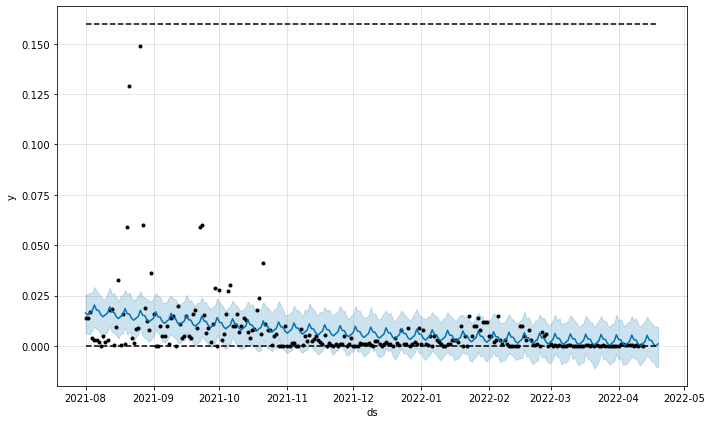

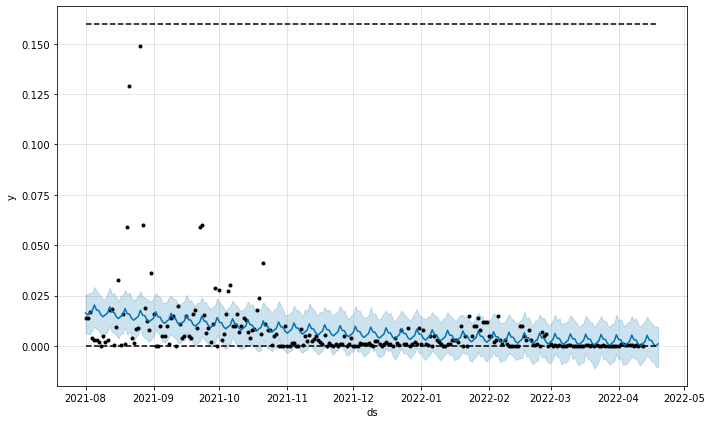

In [70]:
model.plot(forecast, uncertainty=True)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


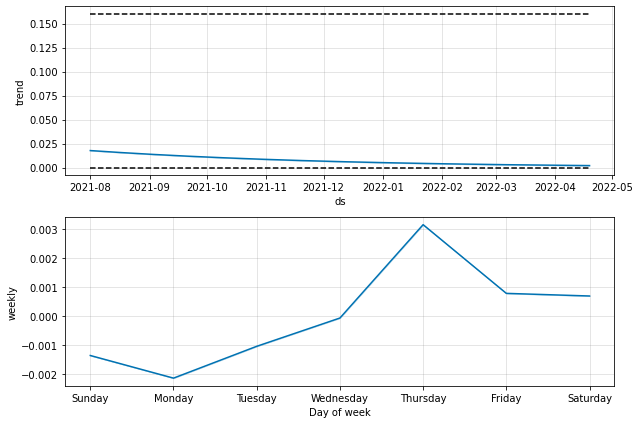

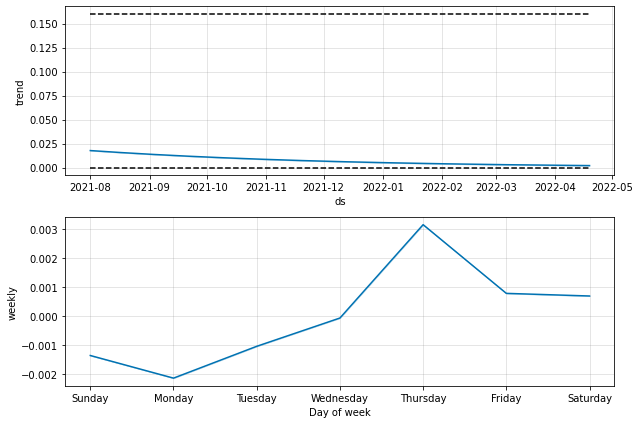

In [71]:
model.plot_components(forecast)

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


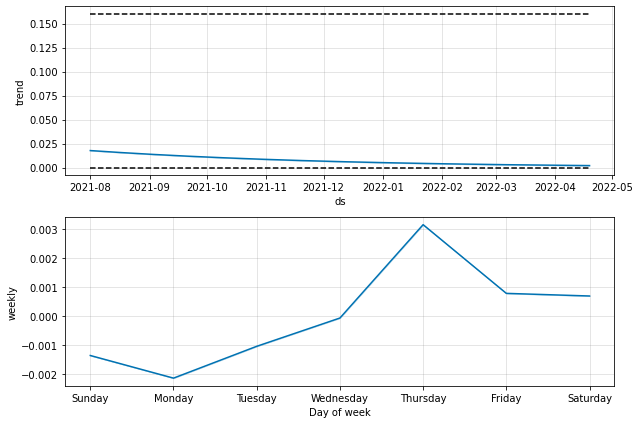

In [72]:
fig1 = model.plot_components(forecast)

In [73]:
forecast['yhat'].describe()

count    262.000000
mean       0.007364
std        0.004713
min       -0.000085
25%        0.003505
50%        0.006407
75%        0.010628
max        0.020301
Name: yhat, dtype: float64

In [74]:
forecast[['ds','yhat']].tail(15)

,ds,yhat
247,2022-04-05,0.001254
248,2022-04-06,0.002210
249,2022-04-07,0.005409
250,2022-04-08,0.003021
251,2022-04-09,0.002911
252,2022-04-10,0.000841
253,2022-04-11,0.000042
254,2022-04-12,0.001120
255,2022-04-13,0.002077
256,2022-04-14,0.005278


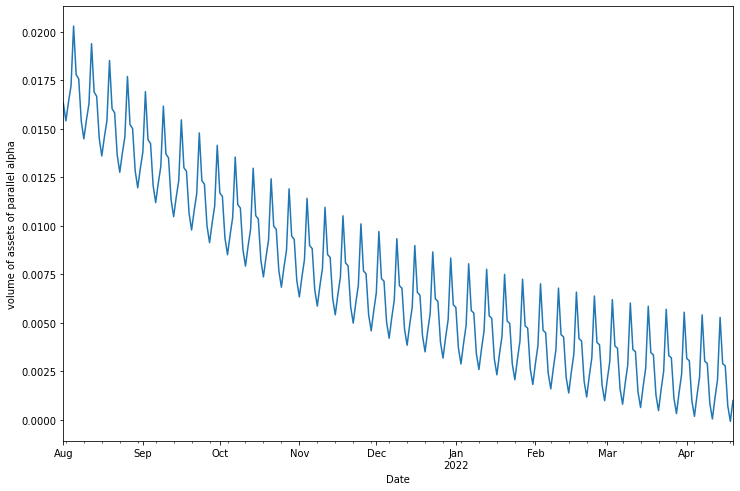

In [75]:
ax = forecast.set_index('ds')['yhat'].plot(figsize=(12, 8))
ax.set_ylabel('volume of assets of parallel alpha')
ax.set_xlabel('Date')

plt.show()

In [76]:
from fbprophet.diagnostics import cross_validation,  performance_metrics
cv_results = cross_validation( model = model, initial = '200 days', horizon = '7 days')
df_p = performance_metrics(cv_results)
df_p

INFO:fbprophet:Making 14 forecasts with cutoffs between 2022-02-18 12:00:00 and 2022-04-05 00:00:00
  0%|                                                    | 0/14 [00:00<?, ?it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Initial log joint probability = -3.2576
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       352.968   1.21018e-08       104.327      0.3545           1       85   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


  7%|███▏                                        | 1/14 [00:00<00:07,  1.76it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Initial log joint probability = -3.30413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       363.265   6.28125e-05       101.964   6.375e-07       0.001      119  LS failed, Hessian reset 
      80       363.271   5.21618e-06       99.6559    5.29e-08       0.001      184  LS failed, Hessian reset 
      99       363.272   1.83936e-07       99.9832      0.2862           1      206   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       363.272   2.63563e-08       99.1198      0.7076      0.7076      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 14%|██████▎                                     | 2/14 [00:01<00:07,  1.69it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Initial log joint probability = -3.39979
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       363.997   4.33454e-09       94.6829      0.2976      0.2976      114   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 21%|█████████▍                                  | 3/14 [00:01<00:06,  1.77it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Initial log joint probability = -3.30268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       378.798   4.52581e-09       99.1381      0.3348      0.3348      106   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 29%|████████████▌                               | 4/14 [00:02<00:05,  1.78it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Initial log joint probability = -3.30169
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       385.522   2.93843e-05       101.504    2.91e-07       0.001      126  LS failed, Hessian reset 
      96       385.527    5.4481e-06       98.5906   5.338e-08       0.001      235  LS failed, Hessian reset 
      99       385.527   1.69246e-06       102.483           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129        385.53   6.92001e-06       99.1212   6.968e-08       0.001      328  LS failed, Hessian reset 
     164       385.533   5.81201e-06       99.8666   5.656e-08       0.001      417  LS failed, Hessian reset 
     187       385.533   4.75773e-09       100.848      0.4471      0.4471      449   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 36%|███████████████▋                            | 5/14 [00:02<00:05,  1.79it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Initial log joint probability = -3.30046
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       394.671   7.94326e-09       99.6386      0.4844      0.4844      114   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 43%|██████████████████▊                         | 6/14 [00:03<00:04,  1.74it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Initial log joint probability = -3.29959
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       401.453   1.26853e-07       99.6008   1.267e-09       0.001      163  LS failed, Hessian reset 
      88       401.453   5.39438e-09       98.2194      0.2674      0.2674      169   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 50%|██████████████████████                      | 7/14 [00:03<00:03,  1.77it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Initial log joint probability = -3.29858
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       410.576   5.38897e-05       100.943   5.436e-07       0.001      130  LS failed, Hessian reset 
      86        410.58   1.10361e-08       97.9192      0.7188      0.7188      182   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 57%|█████████████████████████▏                  | 8/14 [00:04<00:03,  1.79it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Initial log joint probability = -3.29786
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       417.316   1.89894e-08       99.0158      0.2719      0.7699       97   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 64%|████████████████████████████▎               | 9/14 [00:05<00:02,  1.74it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Initial log joint probability = -3.29701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       426.424    2.0064e-09       98.0841      0.1411      0.1411       99   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 71%|██████████████████████████████▋            | 10/14 [00:05<00:02,  1.78it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Initial log joint probability = -3.29644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      36       433.241    0.00015957       100.249   1.589e-06       0.001      111  LS failed, Hessian reset 
      88       433.281   1.49977e-08       101.282      0.3362           1      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 79%|█████████████████████████████████▊         | 11/14 [00:06<00:01,  1.81it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Initial log joint probability = -3.2958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       442.561   5.18404e-09       99.2108      0.2737      0.2737      114   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


 86%|████████████████████████████████████▊      | 12/14 [00:06<00:01,  1.83it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Initial log joint probability = -3.2954
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       449.378   1.26675e-08       96.7398      0.6033      0.6033      102   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


 93%|███████████████████████████████████████▉   | 13/14 [00:07<00:00,  1.79it/s]The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Initial log joint probability = -3.29479
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       458.654   6.09923e-09        98.045      0.4133      0.4133       96   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


100%|███████████████████████████████████████████| 14/14 [00:07<00:00,  1.78it/s]
INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,1 days 00:00:00,0.000005,0.002194,0.002144,20.858372,1.0
1,1 days 12:00:00,0.000001,0.001185,0.000958,1.509693,1.0
2,2 days 00:00:00,0.000026,0.005107,0.004632,18.826238,1.0
3,2 days 12:00:00,0.000009,0.002979,0.001910,3.375561,1.0
4,3 days 00:00:00,0.000008,0.002804,0.002576,7.903749,1.0
5,3 days 12:00:00,0.000005,0.002165,0.001775,5.063556,1.0
6,4 days 00:00:00,0.000006,0.002419,0.002274,5.541399,1.0
7,4 days 12:00:00,0.000008,0.002850,0.002574,4.169667,1.0
8,5 days 00:00:00,0.000005,0.002304,0.001460,5.090896,1.0
9,5 days 12:00:00,0.000034,0.005868,0.005223,18.891292,1.0


In [77]:
df_p['mae'].mean()

0.002407677013384892

In [78]:
df_p['rmse'].mean()

0.0029265570538145086

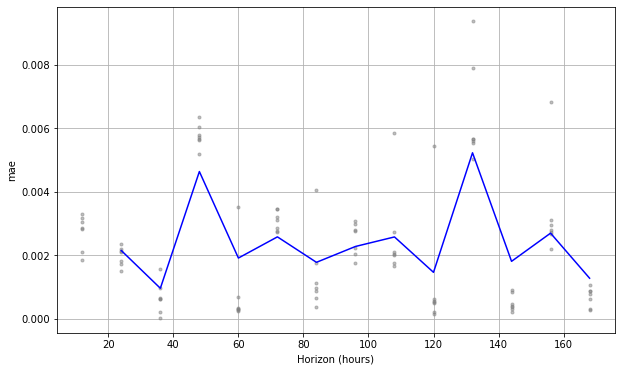

In [79]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(cv_results, metric='mae')

In [80]:
### LSTM